### 1. Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score

import plotly.express as px
import plotly.graph_objects as go 
import seaborn as sns
import matplotlib.pyplot as plt
from dython.nominal import associations

### 2. EDA

Basic statistics

In [2]:
# Import the dataset 
df = pd.read_csv('Walmart_Store_sales.csv')

print('Number of rows in the dataset : {}'.format(df.shape[0]))
print('Number of columns in the dataset : {}'.format(df.shape[1]))
print()

display(df.head())
print()

print('Basics statistics')
display(df.describe(include='all'))
print()

print('Percentage of missing values : ')
display((100*df.isnull().sum()/df.shape[0]).round(2))
print()

print('Variables types : ')
print(df.dtypes)

Number of rows in the dataset : 150
Number of columns in the dataset : 8



,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values : 


Store            0.00
Date            12.00
Weekly_Sales     9.33
Holiday_Flag     8.00
Temperature     12.00
Fuel_Price       9.33
CPI              8.00
Unemployment    10.00
dtype: float64


Variables types : 
Store           float64
Date             object
Weekly_Sales    float64
Holiday_Flag    float64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object


Remove rows where the target is missing

In [3]:
# Missing values in the target variable ==> deleting all affected lines
df.dropna(subset=['Weekly_Sales'], axis=0, inplace=True)
print('Number of rows in the current dataset : {}'.format(df.shape[0]))

print('Percentage of missing values in the new dataset : ')
display((100*df.isnull().sum()/df.shape[0]).round(2))
print()

# Convert columns Store & Holiday_Flag to categorical variables
df['Store'] = df.Store.astype(str).apply(lambda x: x.replace('.0','')).replace('nan',np.nan)
df['Holiday_Flag'] = df.Holiday_Flag.astype(str).apply(lambda x: x.replace('.0','')).replace('nan',np.nan)

Number of rows in the current dataset : 136
Percentage of missing values in the new dataset : 


Store            0.00
Date            13.24
Weekly_Sales     0.00
Holiday_Flag     8.09
Temperature     11.03
Fuel_Price       8.82
CPI              8.09
Unemployment    10.29
dtype: float64

Data Visualization

In [4]:
fig = px.box(df, x = 'Holiday_Flag', y = 'Weekly_Sales', title="Weekly Sales depending on the holiday flag")
fig.show()

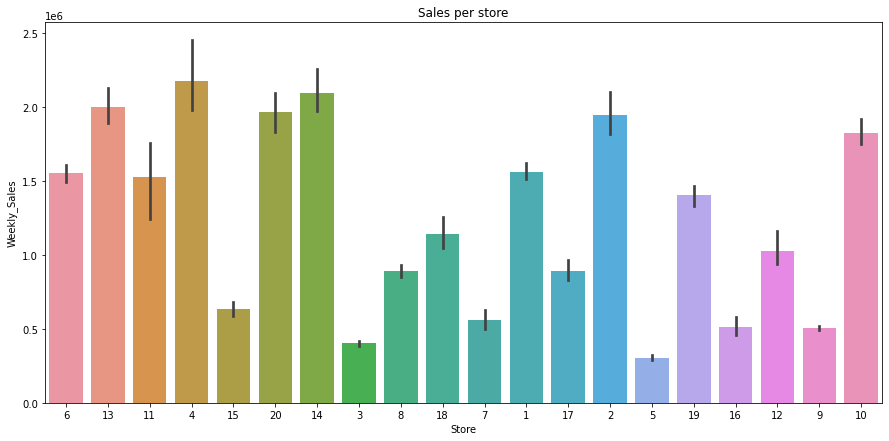

In [5]:
plt.figure(figsize=(15, 7))
g = sns.barplot(data=df, x='Store', y='Weekly_Sales')
g.set_title("Sales per store")
plt.show()

In [6]:
df_test = pd.DataFrame()
df_test["sales"] = df["Weekly_Sales"]
df_test["mois"] = pd.to_datetime(df.Date, format='%d-%m-%Y').dt.strftime("%B")
df_test.head()

,sales,mois
0,1572117.54,February
1,1807545.43,March
3,1244390.03,NaN
4,1644470.66,May
5,1857533.70,May


In [7]:
fig = px.bar(df, x = pd.to_datetime(df.Date, format='%d-%m-%Y').dt.strftime("%B"), y = 'Weekly_Sales', title='Sales per month')
fig.show()

Correlation / Association matrix with the target variable

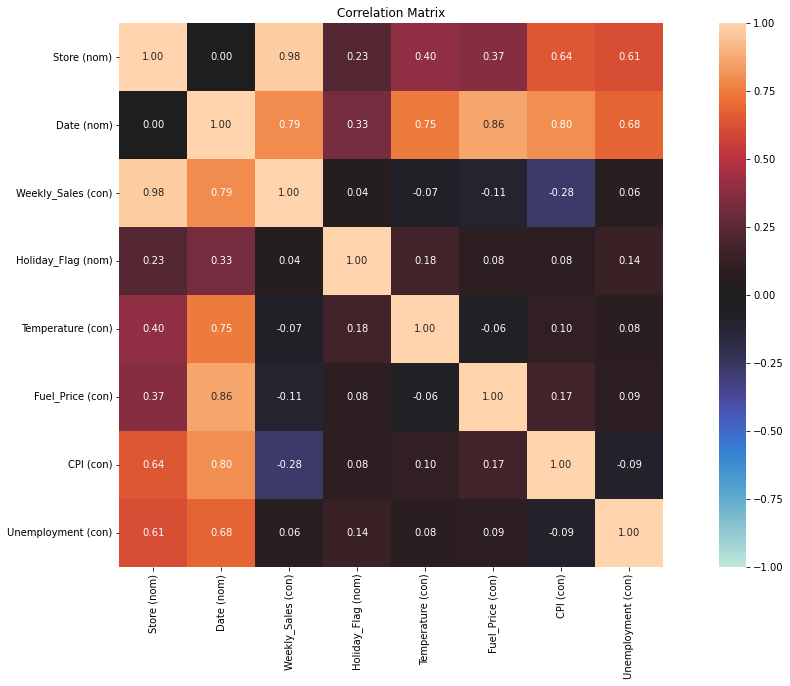

In [8]:
# Correlation matrix between all our variables
    ### Pearson's R for continuous-continuous cases
    ### Correlation Ratio for categorical-continuous cases
    ### Cramer's V or Theil's U for categorical-categorical cases

associations(df,figsize=(20,10), title='Correlation Matrix', mark_columns=True);

### 3. Feature engeneering

In [9]:
# Extracting informations from Date columns
df['Date'] = pd.to_datetime(df.Date, format='%d-%m-%Y')

df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df['day_of_week'] = df.Date.dt.weekday

for col in ['year','month','day', 'day_of_week']:
    df[col] = df[col].astype('Int64')

# Dropping the date coloum, no longer need it
df.drop('Date', axis=1, inplace=True)

print("Features informations : ")
display(df.dtypes)
display(df.head())
display(df[['year','month','day', 'day_of_week']].describe())

Features informations : 


Store            object
Weekly_Sales    float64
Holiday_Flag     object
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
year              Int64
month             Int64
day               Int64
day_of_week       Int64
dtype: object

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,day_of_week
0,6,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18,4
1,13,1807545.43,0,42.38,3.435,128.616064,7.470,2011,3,25,4
3,11,1244390.03,0,84.57,NaN,214.556497,7.346,<NA>,<NA>,<NA>,<NA>
4,6,1644470.66,0,78.89,2.759,212.412888,7.092,2010,5,28,4
5,4,1857533.70,0,NaN,2.756,126.160226,7.896,2010,5,28,4


,year,month,day,day_of_week
count,118.000000,118.000000,118.000000,118.0
mean,2010.822034,6.338983,16.440678,4.0
std,0.812628,3.173664,8.209378,0.0
min,2010.000000,1.000000,1.000000,4.0
25%,2010.000000,4.000000,10.000000,4.0
50%,2011.000000,6.000000,16.500000,4.0
75%,2011.750000,9.000000,24.000000,4.0
max,2012.000000,12.000000,31.000000,4.0


In [10]:
# the column day_of_week is constant (std=0) in our dataset then don't give us any information ==> we can remove it
print(df.day_of_week.unique())
df.drop('day_of_week', axis=1, inplace=True)

<IntegerArray>
[4, <NA>]
Length: 2, dtype: Int64


### 4. Preprocessing

Delete outliers (Numeric features that don't fall within the range : $[\bar{X} - 3\sigma, \bar{X} + 3\sigma]$ will be considered outliers)

In [11]:
print('Dropping outliers...')
for col in ['Temperature', 'Fuel_Price', 'Unemployment']:
    df = df.loc[(df[col].between(df[col].mean() - 3*df[col].std(), df[col].mean() + 3*df[col].std())) | (df[col].isna()),:]

print(df.shape)
print()

Dropping outliers...
(131, 10)



Preprocessing Pipeline

In [12]:
# Detect automatically numeric and categorical features
features = np.delete(df.columns, 1)
numeric_features = []
categorical_features = []


for col in features:
    if ('float' in str(df[col].dtype).lower()) or ('int' in str(df[col].dtype).lower()):
        numeric_features.append(col)
    else:
        categorical_features.append(col)
print('Numeric features : ', numeric_features)
print('Categorical features : ', categorical_features)

Numeric features :  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'day']
Categorical features :  ['Store', 'Holiday_Flag']


In [13]:
# Preprocessor instanciation
numeric_transformer = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='median')),
    ('std', StandardScaler())

])

categorical_transformer = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder(drop='first', handle_unknown='ignore'))

])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

### 5. Train different models

Separate the target from the features and spliting the dataset in train and test set

In [14]:
X = df.drop('Weekly_Sales', axis=1)
y = df.Weekly_Sales

display(X.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day
0,6,NaN,59.61,3.045,214.777523,6.858,2011,2,18
1,13,0,42.38,3.435,128.616064,7.470,2011,3,25
3,11,0,84.57,NaN,214.556497,7.346,<NA>,<NA>,<NA>
4,6,0,78.89,2.759,212.412888,7.092,2010,5,28
5,4,0,NaN,2.756,126.160226,7.896,2010,5,28


##### 1. Train a baseline model

In [15]:
y_train_mean = np.ones_like(y_train) * y_train.mean()
y_test_mean = np.ones_like(y_test) * y_test.mean()

print('R2 score on training set with the baseline model : ', r2_score(y_train, y_train_mean))
print('R2 score on test set :  with the baseline model', r2_score(y_test, y_test_mean))

R2 score on training set with the baseline model :  0.0
R2 score on test set :  with the baseline model -2.220446049250313e-16


The baseline model doesn't seem to give good predictions since the R2 score is very low

##### 2. First model with the most correlated feature to the target ==> Store

In [16]:
X = df.loc[:,['Store']]
y = df.Weekly_Sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [17]:
# Preprocessing on our explanatory variable
encoder = OneHotEncoder(drop='first')

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [18]:
# Train a linear model
lm_univariate = LinearRegression()

lm_univariate.fit(X_train, y_train)

print('R2 score on training set : ', lm_univariate.score(X_train, y_train))
print('R2 score on test set : ', lm_univariate.score(X_test, y_test))

R2 score on training set :  0.9576340393231997
R2 score on test set :  0.9236735851350242


In [19]:
# Cross-validation (10 folds) to detect a potential overfitting
scores = cross_val_score(lm_univariate, X_train, y_train, cv=10)

# print(scores)
print('Mean of Cross-Validation {:.3f}'.format(scores.mean()))
print('Standard Deviation of Cross-Validation {:.3f}'.format(scores.std()))

Mean of Cross-Validation 0.936
Standard Deviation of Cross-Validation 0.045


##### 3. Train a linear estimator with all the features

In [20]:
X = df.drop('Weekly_Sales', axis=1)
y = df['Weekly_Sales']

# Creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [21]:
# Preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [22]:
# Train the model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predictions 
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

# Model performances
print("R2 score on training set : ", r2_score(y_train, y_train_pred))
print("R2 score on test set : ", r2_score(y_test, y_test_pred))

R2 score on training set :  0.9740718051467115
R2 score on test set :  0.9364528193143951


In [23]:
# Cross-validation (10 folds) to detect a potential overfitting
scores = cross_val_score(lm, X_train, y_train, cv=10)

# print(scores)
print('Mean of Cross-Validation {:.3f}'.format(scores.mean()))
print('Standard Deviation of Cross-Validation {:.3f}'.format(scores.std()))

Mean of Cross-Validation 0.943
Standard Deviation of Cross-Validation 0.040


In [24]:
# Get feature names from preprocessing pipeline
num_names = preprocessor.transformers_[0][1][1].get_feature_names_out(numeric_features)
cat_names = preprocessor.transformers_[1][1][1].get_feature_names_out(categorical_features)

feature_names = np.concatenate([num_names, cat_names], axis=0)

# Create a Dataframe with features and the coefficients associated
df_coef_lm = pd.DataFrame(index = feature_names, data = lm.coef_, columns=["coefficients"])
df_coef_lm['abs_coefficients'] = abs(df_coef_lm.coefficients)

print(df_coef_lm[df_coef_lm.abs_coefficients>0].shape)
print("Linear regression Coefficients'")

df_coef_lm.loc[df_coef_lm.abs_coefficients>0, :].sort_values(by='abs_coefficients', ascending=False).head()

(26, 2)
Linear regression Coefficients'


,coefficients,abs_coefficients
Store_5,-1.404353e+06,1.404353e+06
Store_9,-1.275038e+06,1.275038e+06
Store_3,-1.259269e+06,1.259269e+06
Store_16,-1.101418e+06,1.101418e+06
Store_7,-8.817075e+05,8.817075e+05


In [25]:
# Plot coefficients
feature_importance = abs(df_coef_lm.coefficients).sort_values(ascending=False).loc[abs(df_coef_lm.coefficients)>0,]
print(feature_importance.shape)

fig = px.bar(feature_importance)
fig.update_layout(showlegend = False, 
                  title = 'Linear regression coefficients'
                 )
fig.show()

(26,)


As expected, the variable "Store" is the most important feature

##### 4. Train a regularized model

##### 4.1 Ridge

In [26]:
# Regularization with Ridge 
ridge_reg = Ridge()

params = {
    'alpha': np.arange(0.00, 1.0, 0.001)
}
gridsearch_ridge = GridSearchCV(ridge_reg, param_grid = params, cv = 10)
gridsearch_ridge.fit(X_train, y_train)

print("Best hyperparameters : ", gridsearch_ridge.best_params_)
print("Best R2 score : ", gridsearch_ridge.best_score_)
print()
print("R2 score on training set : ", gridsearch_ridge.score(X_train, y_train))
print("R2 score on test set : ", gridsearch_ridge.score(X_test, y_test))

Best hyperparameters :  {'alpha': 0.006}
Best R2 score :  0.9427255223668289

R2 score on training set :  0.9740653797900654
R2 score on test set :  0.937387456112671


In [27]:
# Create a Dataframe with features and the coefficients associated
df_coef_ridge = pd.DataFrame(index = feature_names, data = gridsearch_ridge.best_estimator_.coef_, columns=["coefficients"])
df_coef_ridge['abs_coefficients'] = abs(df_coef_ridge.coefficients)

print('Non-zero coefficients of the RIDGE model')
print(df_coef_ridge[df_coef_ridge.abs_coefficients>0].shape)
df_coef_ridge.loc[df_coef_ridge.abs_coefficients>0, :].sort_values(by='abs_coefficients', ascending=False).head()

Non-zero coefficients of the RIDGE model
(26, 2)


,coefficients,abs_coefficients
Store_5,-1.395875e+06,1.395875e+06
Store_9,-1.264458e+06,1.264458e+06
Store_3,-1.252856e+06,1.252856e+06
Store_16,-1.093936e+06,1.093936e+06
Store_7,-8.803824e+05,8.803824e+05


In [28]:
# Plot coefficients
feature_importance_ridge = abs(df_coef_ridge.coefficients).sort_values(ascending=False).loc[abs(df_coef_ridge.coefficients)>0,]
print(feature_importance_ridge.shape)

fig = px.bar(feature_importance_ridge)
fig.update_layout(showlegend = False, 
                  title="Ridge coefficents",
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

(26,)


##### 4.2 Lasso

In [29]:
# Regularization with lasso 
lasso_reg = Lasso()

params = {
    'alpha': np.arange(100, 1000, 25) 
}
gridsearch = GridSearchCV(lasso_reg, param_grid = params, cv = 10)
gridsearch.fit(X_train, y_train)

print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)
print()
print("R2 score on training set : ", gridsearch.score(X_train, y_train))
print("R2 score on test set : ", gridsearch.score(X_test, y_test))

Best hyperparameters :  {'alpha': 375}
Best R2 score :  0.9434592736752145

R2 score on training set :  0.9737612626031985
R2 score on test set :  0.9439108714820177


In [30]:
# Creating a Dataframe with features and the coefficients associated
df_coef_lasso = pd.DataFrame(index = feature_names, data = gridsearch.best_estimator_.coef_, columns=["coefficients"])
df_coef_lasso['abs_coefficients'] = abs(df_coef_lasso.coefficients)

print('Non-zero coefficients of the LASSO model')
print(df_coef_lasso[df_coef_lasso.abs_coefficients>0].shape)
df_coef_lasso.loc[df_coef_lasso.abs_coefficients>0, :].sort_values(by='abs_coefficients', ascending=False).head()

Non-zero coefficients of the LASSO model
(25, 2)


,coefficients,abs_coefficients
Store_5,-1.365253e+06,1.365253e+06
Store_3,-1.232162e+06,1.232162e+06
Store_9,-1.222251e+06,1.222251e+06
Store_16,-1.072454e+06,1.072454e+06
Store_7,-8.941046e+05,8.941046e+05


In [31]:
# Plot coefficients
feature_importance_lasso = abs(df_coef_lasso.coefficients).sort_values(ascending=False).loc[abs(df_coef_lasso.coefficients)>0,]
print(feature_importance_lasso.shape)

fig = px.bar(feature_importance_lasso)
fig.update_layout(showlegend = False, 
                  title="Lasso coefficents",
                  margin = {'l': 120} 
                 )
fig.show()

(25,)


In [32]:
coef = pd.DataFrame()
coef['coef_linear_regressor'] = df_coef_lm.coefficients
coef['coef_ridge'] = df_coef_ridge.coefficients
coef['coef_lasso'] = df_coef_lasso.coefficients
coef.head()

,coef_linear_regressor,coef_ridge,coef_lasso
Temperature,-37954.320090,-37842.467524,-36707.324745
Fuel_Price,-40814.741798,-40470.988808,-37690.993424
CPI,100863.817981,99663.525904,83355.136346
Unemployment,-97631.959227,-95364.452283,-82550.919697
year,-19332.335560,-18670.986250,-15334.570130


In [33]:
fig = px.line()
fig.add_scatter(x=coef.index, y=coef['coef_linear_regressor'], name='Linear Regression') 
fig.add_scatter(x=coef.index, y=coef['coef_ridge'], name='Ridge') 
fig.add_scatter(x=coef.index, y=coef['coef_lasso'], name='Lasso')
fig.update_layout(
    title="Comparison of model coefficients",
    legend_title="Models",
    )

fig.show()

### Conclusion

We got really got performances with the linear regression and the cross validation confirm that we are not overfitting ==> regularization was not necessary in this case.